<a href="https://colab.research.google.com/github/ChrChr50/Face-Recognition-Neural-Network/blob/main/E2E_Hackthon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### TODO : please modify the line below with your drive organization ###
# path = os.path.join(os.getcwd(), "drive", "MyDrive")

# zip_ref = zipfile.ZipFile("/content/drive/MyDrive/fairface-img-margin025-trainval.zip", 'r')
# zip_ref.extractall("/tmp")
# zip_ref.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from collections import Counter, namedtuple
from itertools import chain
import json
import math
import os
from pathlib import Path
from tqdm.notebook import tqdm, trange
from typing import List, Tuple, Dict, Set, Union
import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split
import torch
import cv2
import glob
import zipfile
import tarfile

# Import Data

In [ ]:

with tarfile.open('/content/drive/MyDrive/face_data/lfw-funneled.tgz') as tar:
    tar.extractall() 


In [ ]:
def setupData(paths, img_size, generate_labels=True):
    '''
    Input
    -------------
    paths : list of strings
        List of string paths regarding image files.
    img_shape : tuple of ints (n, m, 3)
        Tuple that represents the output shape for each image in the numpy matrix. The last
        dimension has to equal 3 as for the RGB channel.
    generate_labels : bool, optional, default: True
        Whether or not to return a 'labels' dict which translates 'y' int data into string labels.
        
    Output
    -------------
    X : numpy array, shape: (n, m, 3)
        X input data, a matrix with (n, m) dimensions and (3) 3-dimensional color channel.
    y : numpy array
        y input data, a single dimension array.
    '''
    n = len(paths)
    X_data = np.zeros(np.insert(img_size, 0, n), dtype='float32')
    y_data = np.zeros(n, dtype='int16')

    common_path = os.path.commonpath(paths)
    labels = dict([(i, label) for i, label in enumerate(os.listdir(common_path))])

    print(f'Data shape -> X: {X_data.shape}, y: {y_data.shape} \n---------------------\n')
    
    inverse_labels = {item[1]:item[0] for item in labels.items()} # Get inverse dict for string search
    for i in range(n):
        img = cv2.imread(paths[i], cv2.IMREAD_COLOR)[:, :, ::-1] # Read image file and invert BGR to RGB
        X_data[i, :, :, :] = cv2.resize(img, img_size[:2], interpolation=cv2.INTER_AREA) / 255

        label = os.path.relpath(paths[i], common_path).partition('/')[0] # Get label from relative path
        y_data[i] = inverse_labels[label]
        
    return (X_data, y_data, labels) if generate_labels else (X_data, y_data)

In [ ]:
%rm '/content/lfw_funneled/pairs.txt'
%rm '/content/lfw_funneled/pairs_01.txt'

In [ ]:
%rm '/content/lfw_funneled/pairs_02.txt'
%rm '/content/lfw_funneled/pairs_03.txt'
%rm '/content/lfw_funneled/pairs_04.txt'
%rm '/content/lfw_funneled/pairs_05.txt'
%rm '/content/lfw_funneled/pairs_06.txt'
%rm '/content/lfw_funneled/pairs_07.txt'
%rm '/content/lfw_funneled/pairs_08.txt'
%rm '/content/lfw_funneled/pairs_09.txt'
%rm '/content/lfw_funneled/pairs_10.txt'

In [ ]:

paths = [path for path in glob.glob('/content/lfw_funneled/**/*.jpg')]

shape = (64, 64, 3)

X_data, y_data, labels = setupData(paths, img_size=shape, generate_labels=True)

Data shape -> X: (13233, 64, 64, 3), y: (13233,) 
---------------------



In [ ]:
X_data[0].shape

(64, 64, 3)

In [ ]:
X_train, X_rem, y_train, y_rem = train_test_split(X_data,y_data, train_size=0.8)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

# CNN

In [ ]:
from keras.engine.input_layer import InputLayer
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import InputLayer

In [ ]:
facerec = Sequential()
facerec.add(InputLayer(input_shape=(64,64,3 ), name='Input_Layer'))
facerec.add(Convolution2D(32, kernel_size = (4, 4), strides = (1, 1), input_shape = (64, 64, 3), activation = 'relu'))
facerec.add(MaxPool2D(pool_size = (2, 2)))
facerec.add(Convolution2D(64, kernel_size = (4, 4), strides = (1, 1), activation = 'relu'))
facerec.add(MaxPool2D(pool_size = (2, 2)))
facerec.add(Flatten())
facerec.add(Dense(64, activation = 'relu'))
facerec.add(Dense(len(labels), activation = 'softmax'))

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.CategoricalCrossentropy()
# metric = tf.keras.metrics

In [ ]:
y_train

array([1898, 1304, 5113, ...,   18, 1962, 1002], dtype=int16)

In [ ]:
indices = y_train
depth = len(labels)
y_train_oh = tf.one_hot(indices, depth)
y_val_oh = tf.one_hot(y_valid,depth)
y_test_oh = tf.one_hot(y_test,depth)

In [ ]:
y_data[y_data==0]

array([0], dtype=int16)

In [ ]:
facerec.summary()
facerec.compile(loss = loss,
                optimizer = optimizer,
                metrics = ['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC(),]
                )

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 61, 61, 32)        1568      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 27, 27, 64)        32832     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 10816)             0         
                                                                 
 dense_8 (Dense)             (None, 64)               

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
trainer = facerec.fit(X_train,
                      y_train_oh,
                      # batch_size = 1,
                      epochs = 20,
                      batch_size=128,
                      verbose=1
                      # validation_data = (tf.convert_to_tensor(test_images[:500],dtype = object), tf.convert_to_tensor(test_names[:500],dtype = object))
                      )
# print(trainer.history['accuracy'])
# facerec.evaluate(np.array(test_images, dtype = object),
#                  np.array(test_names), dtype = object)

facerec.save('facerec.h5')

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


83/83 [==============================] - 101s 1s/step - loss: 8.2690 - accuracy: 0.0391 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5270
Epoch 2/20
83/83 [==============================] - 97s 1s/step - loss: 7.7473 - accuracy: 0.0411 - precision: 0.2500 - recall: 9.4464e-05 - auc: 0.5559
Epoch 3/20
83/83 [==============================] - 96s 1s/step - loss: 7.5650 - accuracy: 0.0419 - precision: 0.6000 - recall: 2.8339e-04 - auc: 0.5624
Epoch 4/20
83/83 [==============================] - 96s 1s/step - loss: 7.3036 - accuracy: 0.0534 - precision: 0.6316 - recall: 0.0023 - auc: 0.5820
Epoch 5/20
83/83 [==============================] - 96s 1s/step - loss: 6.8707 - accuracy: 0.0742 - precision: 0.8000 - recall: 0.0110 - auc: 0.6050
Epoch 6/20
83/83 [==============================] - 100s 1s/step - loss: 6.2597 - accuracy: 0.0966 - precision: 0.8210 - recall: 0.0303 - auc: 0.6406
Epoch 7/20
83/83 [==============================] - 97s 1s/step - loss: 5.4786 - accuracy: 0.1256 -

Text(0, 0.5, 'Accuracy')

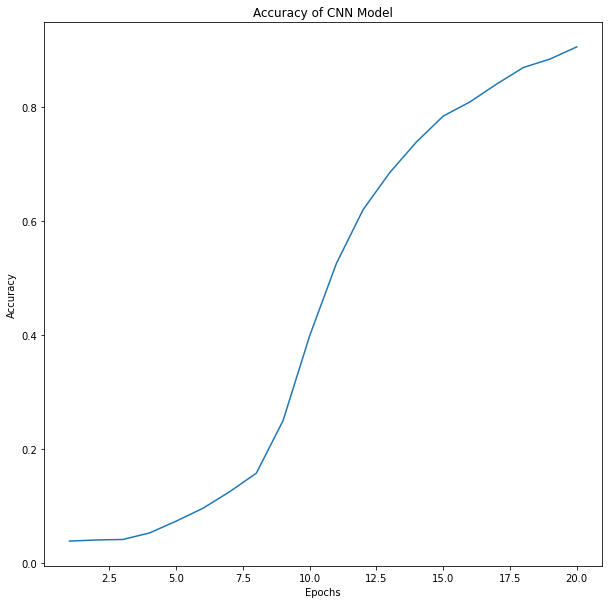

In [ ]:
fig = plt.figure(figsize = (10,10))
plt.plot(np.arange(1,21,1),trainer.history['accuracy'])
plt.title('Accuracy of CNN Model')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [ ]:
trained_facerec = tf.keras.models.load_model('facerec.h5')
sample = [path for path in glob.glob('/content/lfw_funneled/**/*.jpg')][2501]
output = trained_facerec.predict(sample)
print(labels[output])

In [ ]:
facerec.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 61, 61, 32)        1568      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 27, 27, 64)        32832     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 10816)             0         
                                                                 
 dense_6 (Dense)             (None, 64)               

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

In [ ]:
list_of_color =[7,8,11,12,17,22,26,29,31,33,48,54,66,68,76,85,98,106,112,129,143,174,176,177,181,182,184,194,195,208,212,219,231,268,280,289,301,314,322,324,325,327,337,348,358,359,393,395,397,421,424,429,430,432,433,439,442,444,445,446,447,450,451,452,454,461,466,471,480,481,499,498,493]
index = [i-1 for i in list_of_color]
len(index)

73

In [ ]:
colored = X_valid[np.array(index)]
colored_y = tf.one_hot(y_valid[np.array(index)],depth)
# colored_y = y_val_oh[index,:]

In [ ]:
colored_y.shape

TensorShape([73, 5749])

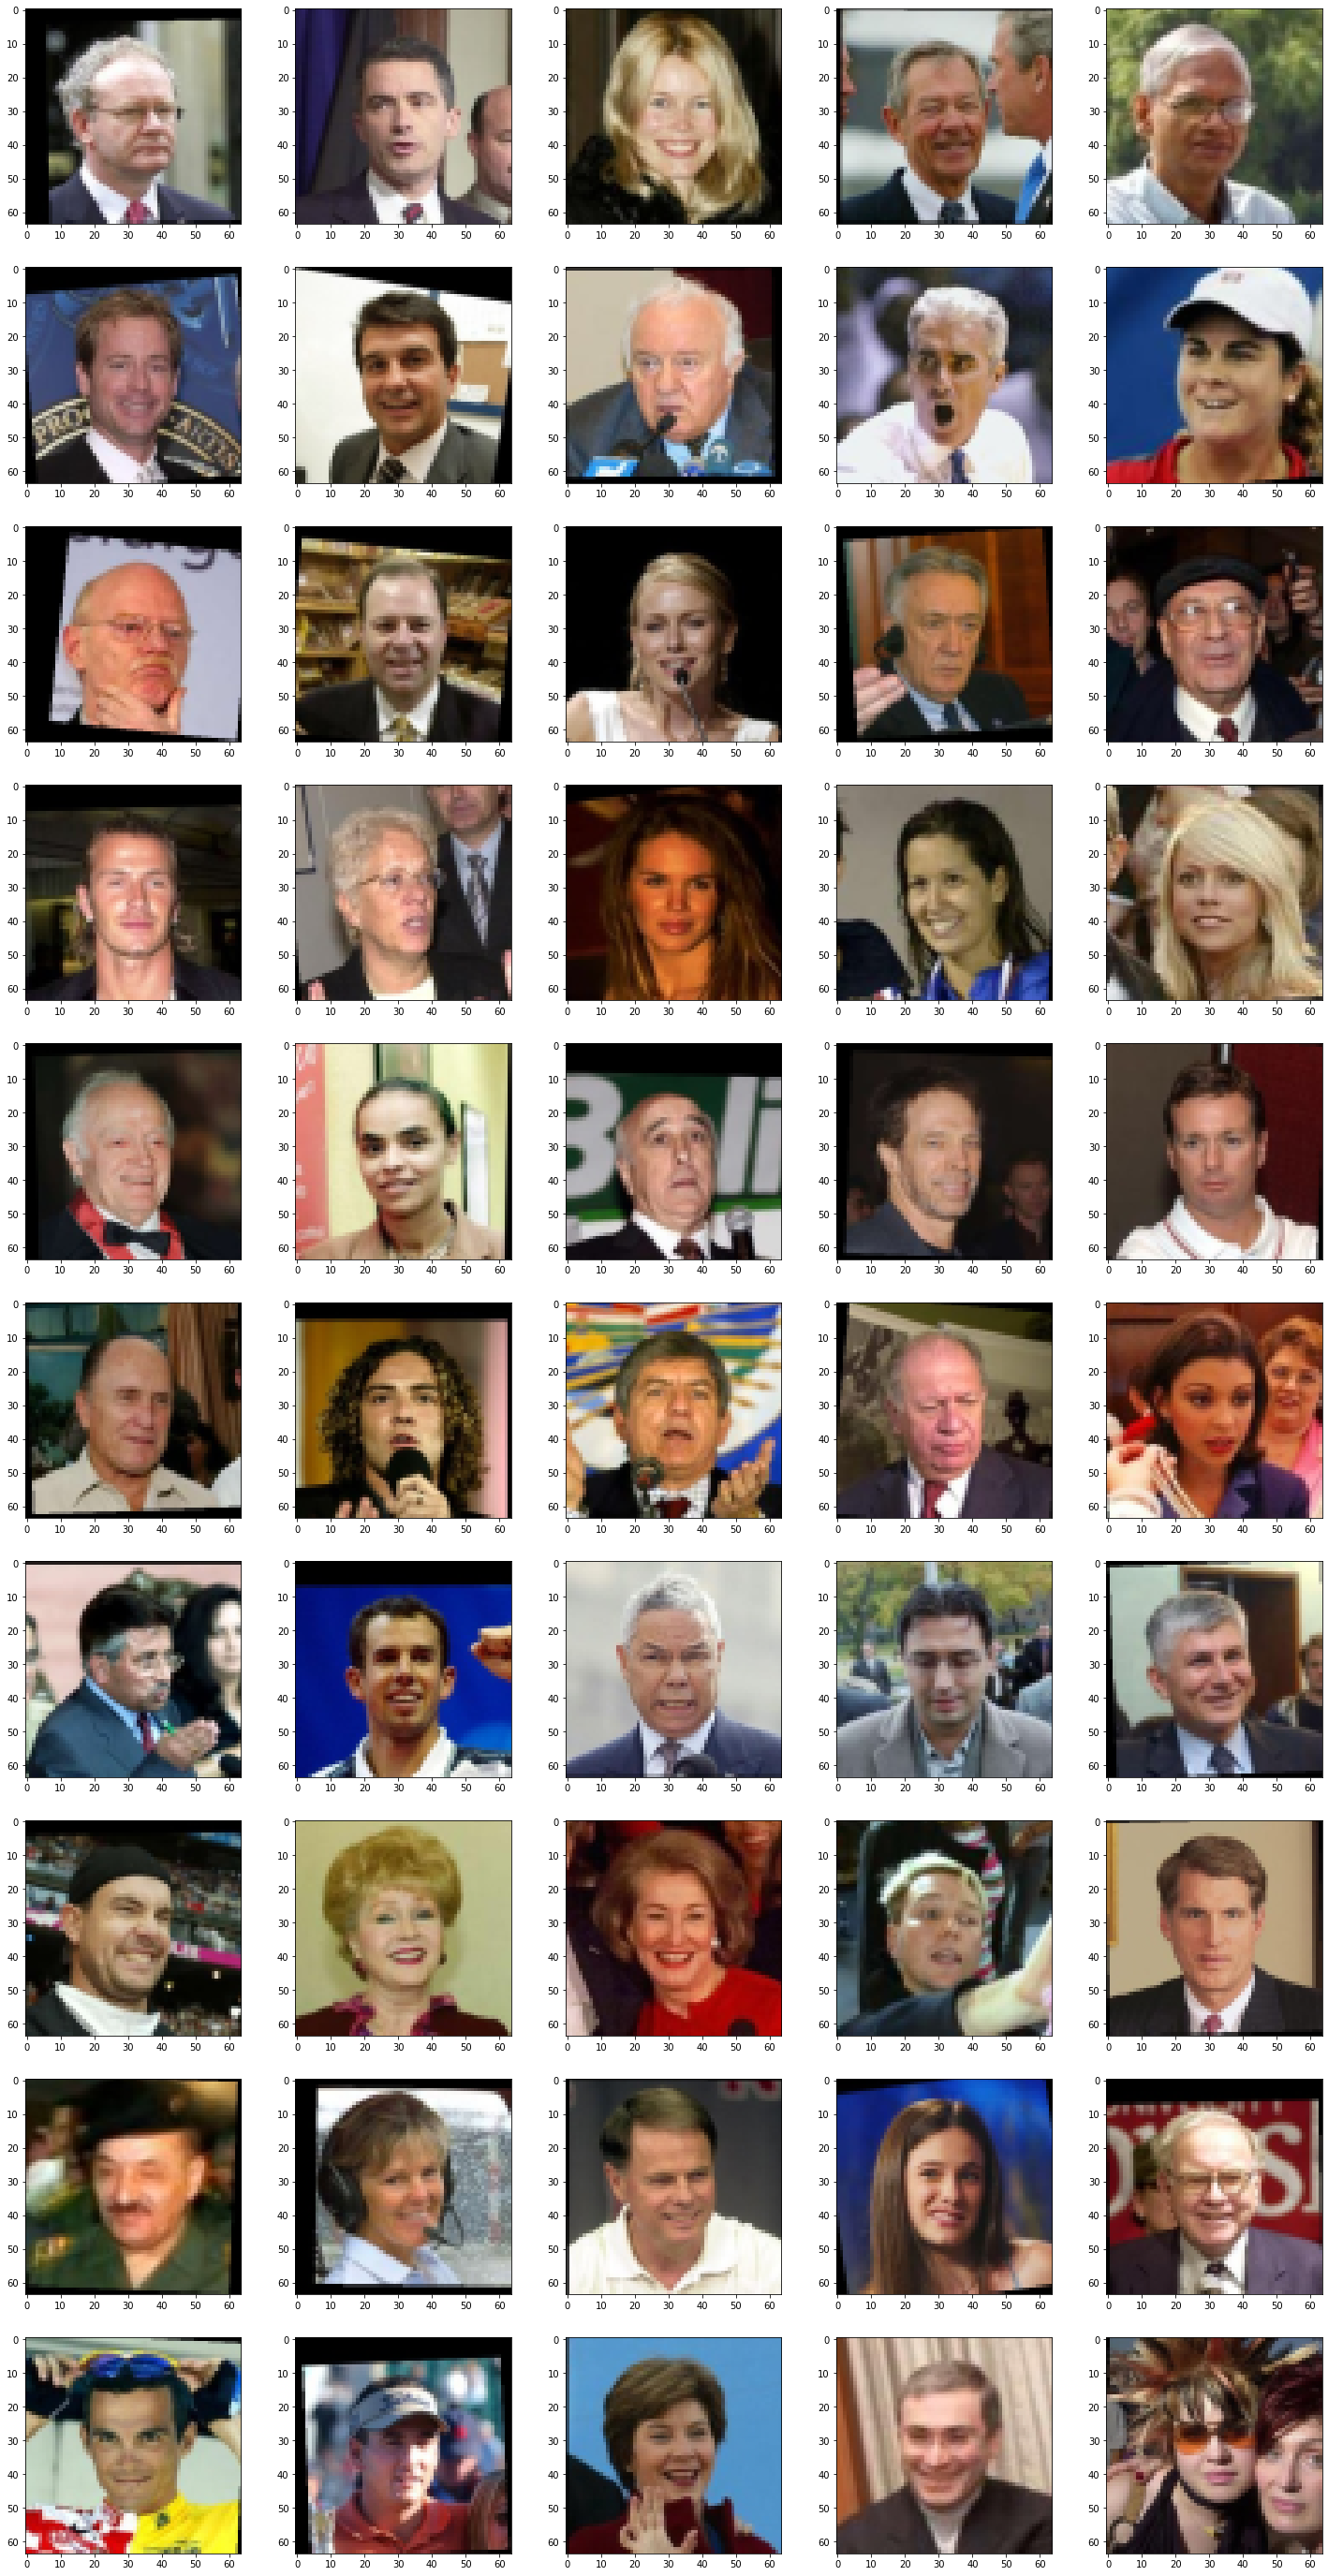

In [ ]:
## select all the pictures of people of color
fig, axs = plt.subplots(10,5)
fig.set_figheight(10*5)
fig.set_figwidth(25)
count =0
for i in range(10):
  for j in range(5):
    axs[i,j].imshow(white_face[count])
    count +=1
# plt.imshow(X_valid[-1],)

In [ ]:
facerec.evaluate(colored, colored_y)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


3/3 [==============================] - 0s 114ms/step - loss: 30.2704 - accuracy: 0.1233 - precision: 0.1698 - recall: 0.1233 - auc: 0.6090


[30.270374298095703,
 0.12328767031431198,
 0.16981132328510284,
 0.12328767031431198,
 0.6089732050895691]

In [ ]:
index_white = [i for i in np.arange(0,500,1) if i not in index][:73]
white_face = X_valid[np.array(index_white)]
y_white = tf.one_hot(y_valid[np.array(index_white)],len(labels))


In [ ]:
y_rem_oh = tf.one_hot(y_rem,depth)

In [ ]:
facerec.evaluate(X_rem, y_rem_oh)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


83/83 [==============================] - 11s 125ms/step - loss: 28.6711 - accuracy: 0.1009 - precision: 0.1406 - recall: 0.0926 - auc: 0.6006


[28.671092987060547,
 0.10086891055107117,
 0.1405622512102127,
 0.09255760908126831,
 0.6006275415420532]

In [ ]:
white_face.shape

(30, 64, 64, 3)

In [ ]:
index_white

In [ ]:
len(labels)

5749